# Single TSC - univariate time series (only "ds1")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa import stattools
import torch

In [2]:
data = pd.read_csv("../../Preprocessing/v2/preprocessed_data_v2.csv")

# Convert "recorded" column to Python datetime objects
data["recorded"] = pd.to_datetime(data["recorded"], format="%Y-%m-%d %H:%M:%S")
data.head(len(data))

,recorded,ct,ss,tsc,ds1,mf1,rf1,ds2,mf2,rf2,ds3,mf3,rf3
0,2021-02-20 20:00:00,110.0,2446,87,42.0,12.0,12.00,47.00,14.00,14.0,25.00,8.00,7.00
1,2021-02-20 20:00:00,110.0,2480,221,36.0,9.0,10.00,60.00,17.00,18.0,16.00,4.00,5.00
2,2021-02-20 20:00:00,110.0,2475,203,38.0,12.0,11.00,38.00,12.00,11.0,19.00,6.00,5.00
3,2021-02-20 20:00:00,110.0,2473,188,41.0,16.0,17.00,39.00,15.00,15.0,24.00,8.00,9.00
4,2021-02-20 20:00:00,110.0,2469,181,41.0,12.0,12.00,37.00,10.00,11.0,23.00,7.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271515,2021-06-18 16:15:00,140.5,2447,278,63.5,36.0,34.75,35.75,24.25,23.5,22.25,15.25,13.75
271516,2021-06-18 16:15:00,140.5,2447,88,93.5,33.5,35.00,69.50,25.00,25.5,48.50,19.00,19.50
271517,2021-06-18 16:15:00,140.5,2446,87,78.0,33.0,33.00,87.00,38.00,38.0,68.00,31.00,30.00
271518,2021-06-18 16:15:00,140.5,2480,221,81.5,24.5,26.00,83.00,28.00,28.5,89.50,31.50,31.50


### Why LSTM > RNN?
    1) Corrects for vanishing and exploding gradients
    2) Simpler training
    3) Better for processing very long sequences

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ACF and PACF plots to determine optimal lag length (i.e. train window) for LSTM model for each TSC

In [4]:
# Relevant TSCs linked to Coronation drive
tscs = [87, 88, 278, 181, 188, 203, 221, 364]

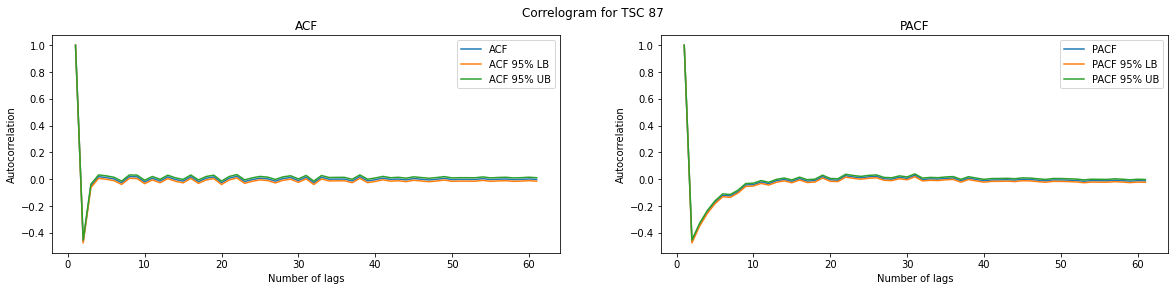

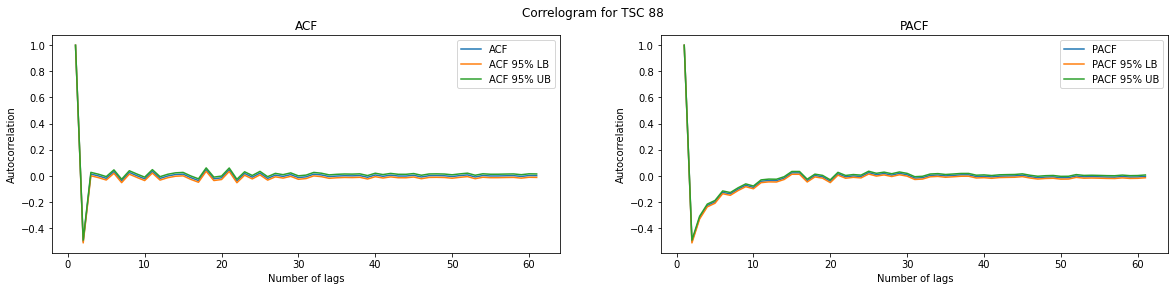

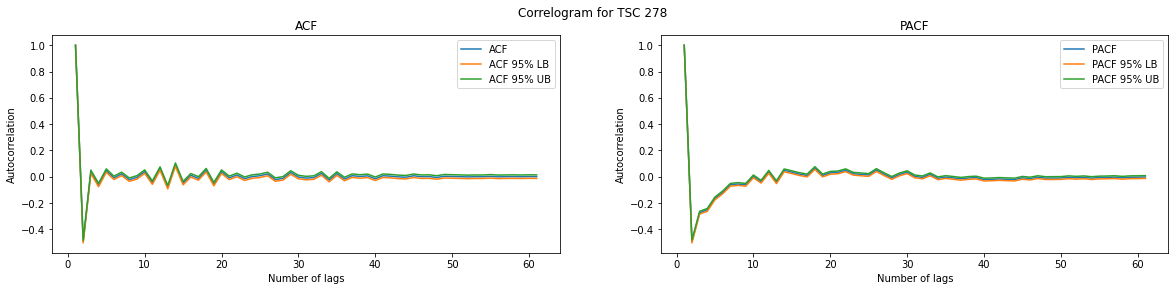

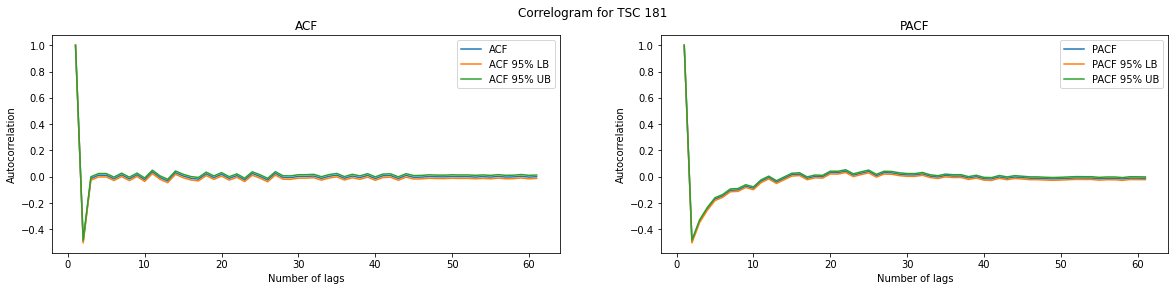

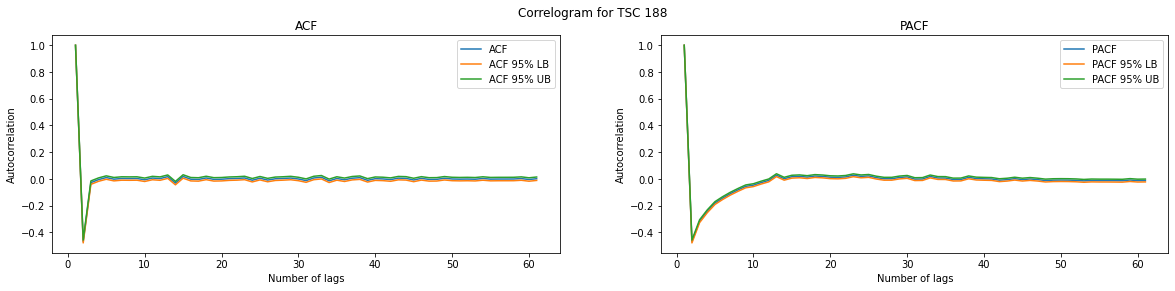

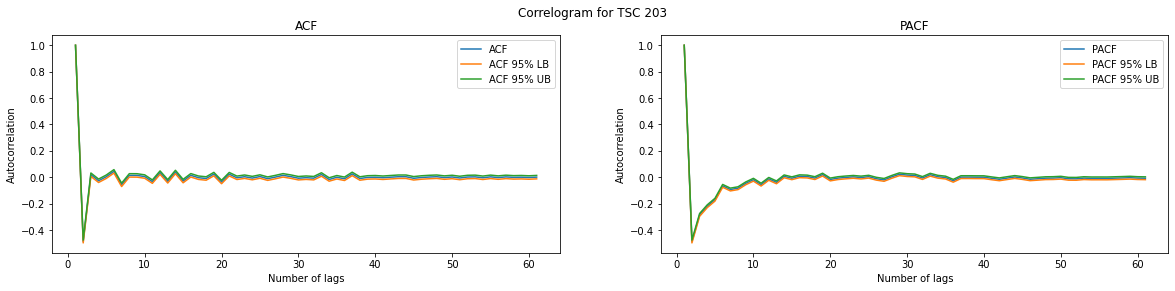

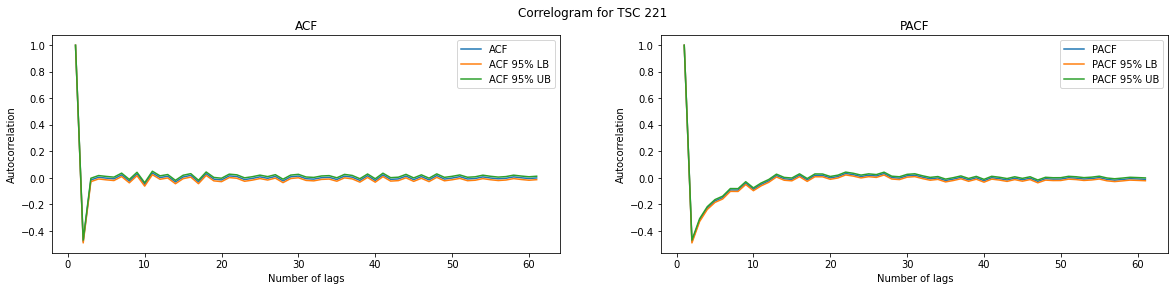

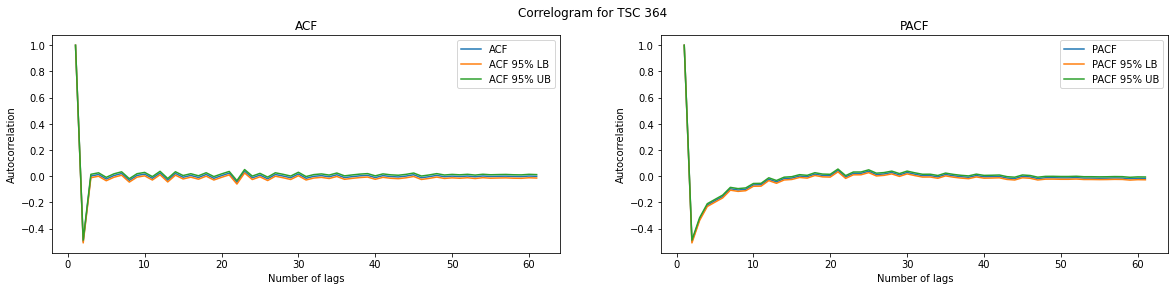

In [5]:
tsc_windows = dict()
for tsc in tscs:
    dataset = data[data["tsc"] == tsc]["ds1"].values.astype("float32").reshape(-1, 1)
    
    # Correct for 0 values before applying log and first difference filters (log(0) = -inf)
    temp_dataset = np.copy(dataset)
    for i in range(len(dataset)):
        if temp_dataset[i] == 0:
            temp_dataset[i] += 0.0001
    
    # Apply log filter then first difference filter (corrects for non-stationarity in the mean and variance)
    temp_dataset = np.diff(np.log(temp_dataset), axis=0)
    
    # With 5 min intervals, nlags=60 corresponds to 5*60 = 300 mins or 300/60 = 5 hours sliding windows
    acf, confint_acf = stattools.acf(temp_dataset, nlags=60, fft=True, alpha=0.05)
    pacf, confint_pacf = stattools.pacf(temp_dataset, nlags=60, alpha=0.05)
    
    # Plot Correlograms for each TSC
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 4))
    axes[0].plot(range(1, len(acf) + 1), acf, label="ACF")
    axes[0].plot(range(1, len(acf) + 1), confint_acf[:, 0], label="ACF 95% LB")
    axes[0].plot(range(1, len(acf) + 1), confint_acf[:, 1], label="ACF 95% UB")
    axes[0].set_xlabel("Number of lags")
    axes[0].set_ylabel("Autocorrelation")
    axes[0].set_title("ACF")
    axes[0].legend()

    axes[1].plot(range(1, len(pacf) + 1), pacf, label="PACF")
    axes[1].plot(range(1, len(pacf) + 1), confint_pacf[:, 0], label="PACF 95% LB")
    axes[1].plot(range(1, len(pacf) + 1), confint_pacf[:, 1], label="PACF 95% UB")
    axes[1].set_xlabel("Number of lags")
    axes[1].set_ylabel("Autocorrelation")
    axes[1].set_title("PACF")
    axes[1].legend()

    fig.suptitle(f"Correlogram for TSC {tsc}")
    
    # Find optimal lag based on hypothesis testing, sqrt(T)*phi_hat ~ N(0, 1)
    # H0: No i-th order partial autocorrelation (phi = 0)
    # H1: There is i-th order partial autocorrelation (phi =/= 0)
    optimal_lag = -1
    for lag in range(len(pacf)):
        if np.sqrt(len(temp_dataset)) * abs(pacf[lag]) > 1.96:
            optimal_lag = lag
    
    tsc_windows[tsc] = optimal_lag

In [6]:
tsc_windows

{87: 60, 88: 50, 278: 53, 181: 60, 188: 60, 203: 51, 221: 60, 364: 60}

### Preprocessing for LSTM model
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python

In [7]:
max_samples = 1000

# Scale features to [0, 1] to help in training
dataset = data[data["tsc"] == tsc]["ds1"].values.astype("float32").reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Train with only max_samples number of samples
dataset = dataset[:max_samples]

print(dataset[:5])
print(dataset.shape)

[[0.18120806]
 [0.17785235]
 [0.2080537 ]
 [0.25055927]
 [0.15212527]]
(1000, 1)


In [8]:
# Training set = 90%, testing set = 10%
train_size = int(len(dataset)*(9/10))
test_size = len(dataset) - train_size

train_data, test_data = dataset[:train_size, :], dataset[train_size:, :]
train_data = torch.cuda.FloatTensor(train_data).view(-1)
test_data = torch.cuda.FloatTensor(test_data).view(-1)

In [9]:
# Transforms training data into required time series sequence and label form for training
def to_sequences(train_data, train_window=1):
    sequences = []

    for i in range(len(train_data) - train_window - 1):
        # print(i)
        # ADD SECOND INDEX FOR MULTIVARIATE TIME SERIES
        sequence = train_data[i:i + train_window].view(-1)
        label = train_data[i + train_window].view(-1)
        sequences.append((sequence, label))
        
    return sequences

In [10]:
# Train window = optimal lag length for given TSC
train_window = tsc_windows[tsc]
train_seq = to_sequences(train_data, train_window)

print(train_seq[:2])

[(tensor([0.1812, 0.1779, 0.2081, 0.2506, 0.1521, 0.2114, 0.2148, 0.1991, 0.1007,
        0.1980, 0.1678, 0.1834, 0.1879, 0.2081, 0.1767, 0.1544, 0.2349, 0.1678,
        0.1711, 0.2383, 0.1790, 0.2260, 0.3154, 0.1342, 0.1544, 0.1298, 0.2550,
        0.1946, 0.1767, 0.2081, 0.1700, 0.1790, 0.1521, 0.2215, 0.1700, 0.1186,
        0.1655, 0.1477, 0.1141, 0.1991, 0.1007, 0.1633, 0.1879, 0.0828, 0.1141,
        0.1544, 0.1588, 0.1275, 0.0940, 0.0805, 0.1521, 0.1242, 0.1298, 0.1163,
        0.0761, 0.1242, 0.1007, 0.1040, 0.0761, 0.0604], device='cuda:0'), tensor([0.0940], device='cuda:0')), (tensor([0.1779, 0.2081, 0.2506, 0.1521, 0.2114, 0.2148, 0.1991, 0.1007, 0.1980,
        0.1678, 0.1834, 0.1879, 0.2081, 0.1767, 0.1544, 0.2349, 0.1678, 0.1711,
        0.2383, 0.1790, 0.2260, 0.3154, 0.1342, 0.1544, 0.1298, 0.2550, 0.1946,
        0.1767, 0.2081, 0.1700, 0.1790, 0.1521, 0.2215, 0.1700, 0.1186, 0.1655,
        0.1477, 0.1141, 0.1991, 0.1007, 0.1633, 0.1879, 0.0828, 0.1141, 0.1544,
      

### PyTorch LSTM implementation

In [11]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, hidden_layers=2, output_size=1, dropout=0):
        """
        Inputs:
            input_size - corresponds to the number of features in the input.
            hidden_layer_size - specifies the number of hidden layers along with the number of neurons in each layer.
            output_size - the number of items in the output.
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers = hidden_layers

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, hidden_layers, dropout=dropout)

        self.fc1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
        
        # Adding an additional dense layer here
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)

        # Hidden and cell states initialisation
        self.hidden_cell = (torch.zeros(hidden_layers, 1, self.hidden_layer_size).to(device),
                            torch.zeros(hidden_layers, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        """
        Same as model(input_seq).item()
        """
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        fc1_out = self.fc1(lstm_out)
        predictions = self.fc2(fc1_out.view(len(input_seq), -1))
        return predictions[-1]

### Loss function and optimiser

In [12]:
model = LSTM().cuda()
# MSE as loss function
loss_fn = torch.nn.MSELoss()
# Adam optimiser for optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

LSTM(
  (lstm): LSTM(1, 200, num_layers=2)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)


### Training the LSTM model

In [13]:
# Training iterations
num_epochs = 100
# To plot training loss curve after completion of training
loss = []

for i in range(1, num_epochs + 1):
    for seq, label in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(model.hidden_layers, 1, model.hidden_layer_size).to(device),
                             torch.zeros(model.hidden_layers, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_fn(y_pred, label)
        single_loss.backward()
        optimizer.step()

    # if i % 10 == 1:
    print(f'Epoch {i} loss: {single_loss.item():10.8f}')
    
    loss.append(single_loss.item())

Epoch 1 loss: 0.00482827
Epoch 2 loss: 0.00946852
Epoch 3 loss: 0.01315239
Epoch 4 loss: 0.01236399
Epoch 5 loss: 0.00910297
Epoch 6 loss: 0.00622516
Epoch 7 loss: 0.00467205
Epoch 8 loss: 0.00381924
Epoch 9 loss: 0.00337589
Epoch 10 loss: 0.00284602
Epoch 11 loss: 0.00206372
Epoch 12 loss: 0.00123084
Epoch 13 loss: 0.00071879
Epoch 14 loss: 0.00019160
Epoch 15 loss: 0.00035943
Epoch 16 loss: 0.00025183
Epoch 17 loss: 0.00023057
Epoch 18 loss: 0.00004932
Epoch 19 loss: 0.00004453
Epoch 20 loss: 0.00001533
Epoch 21 loss: 0.00001612
Epoch 22 loss: 0.00001430
Epoch 23 loss: 0.00000544
Epoch 24 loss: 0.00000024
Epoch 25 loss: 0.00000071
Epoch 26 loss: 0.00001171
Epoch 27 loss: 0.00003945
Epoch 28 loss: 0.00005349
Epoch 29 loss: 0.00005072
Epoch 30 loss: 0.00003337
Epoch 31 loss: 0.00002462
Epoch 32 loss: 0.00001294
Epoch 33 loss: 0.00002824
Epoch 34 loss: 0.00001161
Epoch 35 loss: 0.00001651
Epoch 36 loss: 0.00000624
Epoch 37 loss: 0.00005432
Epoch 38 loss: 0.00001389
Epoch 39 loss: 0.0000

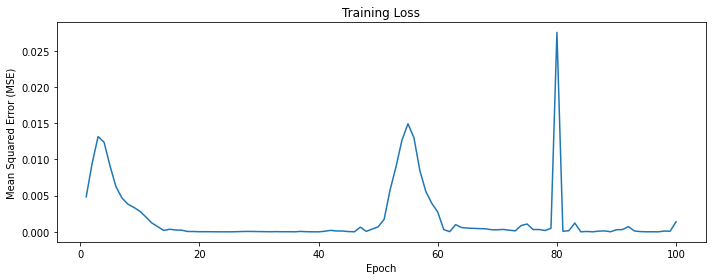

In [14]:
# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, i + 1), loss)
# plt.plot(range(1, i), loss)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training Loss")
plt.tight_layout()

### Predictions using trained model

In [15]:
pred_window = 12
pred_df = data[data["tsc"] == tsc][["recorded", "ds1"]][train_size - train_window:max_samples]
pred_df["scaled_ds1"] = train_data.tolist()[-train_window:] + test_data.tolist()
pred_df.head(len(pred_df))

,recorded,ds1,scaled_ds1
6721,2021-02-23 18:00:00,93.5,0.627517
6730,2021-02-23 18:05:00,83.0,0.557047
6737,2021-02-23 18:10:00,87.5,0.587248
6745,2021-02-23 18:15:00,86.5,0.580537
6755,2021-02-23 18:20:00,42.0,0.281879
...,...,...,...
7964,2021-02-24 06:55:00,65.5,0.439597
7973,2021-02-24 07:00:00,71.0,0.476510
7979,2021-02-24 07:05:00,66.5,0.446309
7990,2021-02-24 07:10:00,87.5,0.587248


In [16]:
# pred_dict = dict()
# model.eval()

# test_inputs = list(pred_df["scaled_ds1"].values[:train_window])

# for i in range(len(pred_df) - train_window):
#     seq = torch.cuda.FloatTensor(test_inputs[-train_window:])
#     with torch.no_grad():
#         pred = model(seq).item()
#         model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
#                         torch.zeros(1, 1, model.hidden_layer_size).to(device))
#         test_inputs.append(pred)
        
#         pred_dict[pred_df["recorded"].iloc[i + train_window]] = [pred, 1]

### Predict 12 time steps (5*12 ~ 60 minutes) into the future and keep updating these future predictions  (via averaging) with each timestep into the future. In other words, each timestep in test_data has 12 predictions averaged out to form a single prediction

In [17]:
pred_dict = dict()
model.eval()

for i in range(len(pred_df) - train_window - pred_window):
    test_inputs = list(pred_df["scaled_ds1"].values[i:i + train_window])
    seq = torch.cuda.FloatTensor(test_inputs)
    
    for j in range(pred_window):
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                            torch.zeros(1, 1, model.hidden_layer_size).to(device))
            pred = model(seq).item()
            if pred_dict.get(pred_df["recorded"].iloc[i + train_window + j]) is None:
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]] = [pred, 1]
            else:
                mean = pred_dict[pred_df["recorded"].iloc[i + train_window + j]][0]
                n = pred_dict[pred_df["recorded"].iloc[i + train_window + j]][1]

                # Inremental averaging
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]][0] = (n*mean + pred)/(n + 1)
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]][1] += 1
                
        test_inputs.append(pred)
        seq = torch.cuda.FloatTensor(test_inputs[-train_window:])

In [18]:
pred_dict

{Timestamp('2021-02-23 23:00:00'): [0.1004706546664238, 1],
 Timestamp('2021-02-23 23:05:00'): [0.11530996859073639, 2],
 Timestamp('2021-02-23 23:10:00'): [0.11993148922920227, 3],
 Timestamp('2021-02-23 23:15:00'): [0.1243218183517456, 4],
 Timestamp('2021-02-23 23:20:00'): [0.1301034212112427, 5],
 Timestamp('2021-02-23 23:25:00'): [0.13714013993740082, 6],
 Timestamp('2021-02-23 23:30:00'): [0.14396287287984574, 7],
 Timestamp('2021-02-23 23:35:00'): [0.1499300403520465, 8],
 Timestamp('2021-02-23 23:40:00'): [0.15801198283831278, 9],
 Timestamp('2021-02-23 23:45:00'): [0.16737619265913964, 10],
 Timestamp('2021-02-23 23:50:00'): [0.17588550529696725, 11],
 Timestamp('2021-02-23 23:55:00'): [0.1844194494187832, 12],
 Timestamp('2021-02-24 00:00:00'): [0.18714045298596224, 12],
 Timestamp('2021-02-24 00:05:00'): [0.18967503557602564, 12],
 Timestamp('2021-02-24 00:10:00'): [0.1930709139754375, 12],
 Timestamp('2021-02-24 00:15:00'): [0.1948495525866747, 12],
 Timestamp('2021-02-24 0

In [19]:
pred_df = pred_df.iloc[train_window:]

# Merge predictions results with pred_df dataframe
temp_df = pd.DataFrame(pred_dict.values(), index=pred_dict.keys(), columns=["scaled_pred", "n"])
temp_df.insert(0, column="recorded", value=temp_df.index)
temp_df.reset_index(drop=True)

pred_df = pred_df.merge(temp_df, on="recorded")

In [20]:
# Need to reverse transform from [0, 1] back to original "ds1"
pred_df["pred"] = scaler.inverse_transform(pred_df["scaled_pred"].values.reshape(-1, 1))
pred_df.head(len(pred_df))

,recorded,ds1,scaled_ds1,scaled_pred,n,pred
0,2021-02-23 23:00:00,12.750000,0.085570,0.100471,1,14.970127
1,2021-02-23 23:05:00,5.000000,0.033557,0.115310,2,17.181185
2,2021-02-23 23:10:00,10.666667,0.071588,0.119931,3,17.869792
3,2021-02-23 23:15:00,7.000000,0.046980,0.124322,4,18.523951
4,2021-02-23 23:20:00,11.500000,0.077181,0.130103,5,19.385410
...,...,...,...,...,...,...
94,2021-02-24 06:50:00,67.000000,0.449664,0.444586,5,66.243346
95,2021-02-24 06:55:00,65.500000,0.439597,0.448027,4,66.756014
96,2021-02-24 07:00:00,71.000000,0.476510,0.449955,3,67.043225
97,2021-02-24 07:05:00,66.500000,0.446309,0.449602,2,66.990643


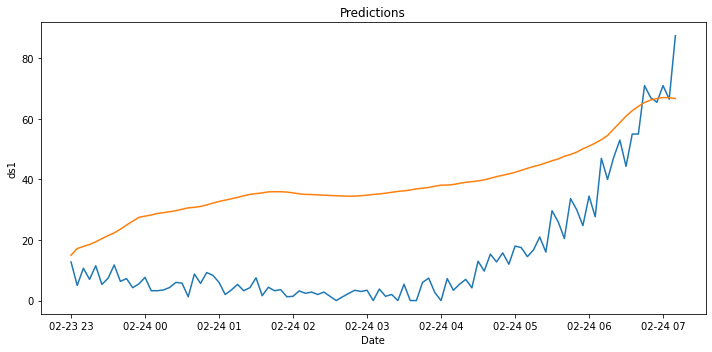

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(pred_df["recorded"], pred_df["ds1"])
plt.plot(pred_df["recorded"], pred_df["pred"])
plt.xlabel("Date")
plt.ylabel("ds1")
plt.title("Predictions")
plt.tight_layout()